In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
data=pd.read_csv('data9-07.csv',parse_dates=['date'],index_col=['date'])

data.drop(columns=["Unnamed: 0","_id","serial","day","month","hour","minute","created", "second" , "__v"],inplace=True)
data.sort_index(inplace=True)
data.head()

,hum,temp,name
date,,,
2021-05-05 23:23:12,58.0,22.0,SB 0 - 2 cabinet
2021-05-05 23:28:12,58.6,21.7,SB 0 - 2 cabinet
2021-05-05 23:33:12,58.8,21.5,SB 0 - 2 cabinet
2021-05-05 23:37:52,52.2,22.8,Salle d'onduleur DSIT 1 - 1
2021-05-05 23:37:52,52.2,22.8,Filter


In [53]:
df=data[data["name"]=="SB 0 - 3 cabinet"]["2021-05-08":"2021-05-09"]
df["delta"]=df.temp-df.shift().temp
d=df.rename(columns={"temp":"average"})

In [58]:
#peak detection 
WINDOW=50
#WINDOW changes depending on how much data we have and how smooth we want our signal to be 
# in the same folder ,there are pictures of graphs with a window of 30 and a window of 100 for 2 months of data ( 14 696 events ) 
#to vizualize the effect of WINDOW 
MAX=25
MIN=17
# max and min temperatures
peaks=[]
dates=[]
temps=[]
# if variation_control allows us to take in consideration large variations in temperature even withing the min-max range 
# here the variation_control represents 20% of the min max range 
variation_control=(MAX-MIN)/5

last_ind=d.index.get_loc(d.index[len(d.index)-1])
#last index of the dataframe i worked with
peaks.append("first")
dates.append(d.iloc[[0]].index[0])
temps.append(d.iloc[[0]].average[0])
# keeping track of the first values 
ind=1
while ind<last_ind : 
#appending values that represent a peak with a large variation , or values greater than the max or lower than the min with a variation greater than 0.1 
    if (d.iloc[[ind]].delta[0]>=variation_control and d.iloc[[ind+1]].delta[0]<=-variation_control )or (d.iloc[[ind]].delta[0]>=variation_control and d.iloc[[ind+1]].delta[0]<0) or  (d.iloc[[ind]].delta[0]>0 and d.iloc[[ind+1]].delta[0]<=-variation_control) or (d.iloc[[ind]].average[0]==MAX) or(d.iloc[[ind]].average[0]>=MAX and  d.iloc[[ind]].delta[0]>0.1 and d.iloc[[ind+1]].delta[0]<=-0.1 ) :
       # appending type of peak , date and temperature 
        peaks.append("high")
       

        dates.append(d.iloc[[ind]].index[0])
     
        
        temps.append(d.iloc[[ind]].average[0])
        #

        ind+=1

    elif  (d.iloc[[ind]].delta[0]<=-variation_control and d.iloc[[ind+1]].delta[0]>=variation_control)or(d.iloc[[ind]].delta[0]<0 and d.iloc[[ind+1]].delta[0]>=variation_control) or (d.iloc[[ind]].delta[0]<=-variation_control and d.iloc[[ind+1]].delta[0]>0)or(d.iloc[[ind]].average[0]==MIN) or (d.iloc[[ind]].average[0]<=MIN and  d.iloc[[ind]].delta[0]<=-0.1 and d.iloc[[ind+1]].delta[0]>=0.1) :
       
        peaks.append("low")
  

        dates.append(d.iloc[[ind]].index[0])
  
        
        temps.append(d.iloc[[ind]].average[0])
  
        ind+=1
    elif np.abs(d.iloc[[ind]].delta[0])>=variation_control :
        peaks.append("none")
        # variation = temp[i]-temp[i-1] => appending both temp[i] and temp[i-1]  with their dates 
        peaks.append("large variation ")
        dates.append(d.iloc[[ind-1]].index[0])
        dates.append(d.iloc[[ind]].index[0])
        
        temps.append(d.iloc[[ind-1]].average[0])
        temps.append(d.iloc[[ind]].average[0])
        
#if the conditions above aren't true it starts calculating an average of the non-important values until he finds solthing greater than a max or lower than min   
    else : 
        av=[]
        window=WINDOW
        while ind<last_ind and window>=0 and d.iloc[[ind]].average[0]>=MIN and d.iloc[[ind]].average[0]<=MAX and np.abs(d.iloc[[ind]].delta[0])<variation_control :
            av.append(d.iloc[[ind]].average[0])
            window-=1
            ind+=1
        peaks.append("none")
        # none means not a peak  not or >= MAX or <=MIN or large variation 
        dates.append(d.iloc[[ind]].index[0])
        if len(av)!= 0 :
            temps.append(sum(av)/len(av))
        else :
            temps.append(d.iloc[[ind]].average[0])
   
    ind+=1
# appending the last value since this data is static 
peaks.append("last")
dates.append(d.iloc[[last_ind]].index[0])
temps.append(d.iloc[[last_ind]].average[0])
# new dataframe with the optimized values 
# type contains values IN [ " high" , " low " , " large variation " , " none "] 
optimized=pd.DataFrame({"date":dates , "type": peaks , "temp" : temps })      
optimized.set_index("date",inplace=True)

# just to check how many values we filtered  
print(" initial values : " , df.shape[0] ," after optimization : ",optimized.shape[0])
print( " narrowed by : -",round((1-(optimized.shape[0]/df.shape[0]))*100,2)," %" )

 initial values :  575  after optimization :  81
 narrowed by :  85.91  %


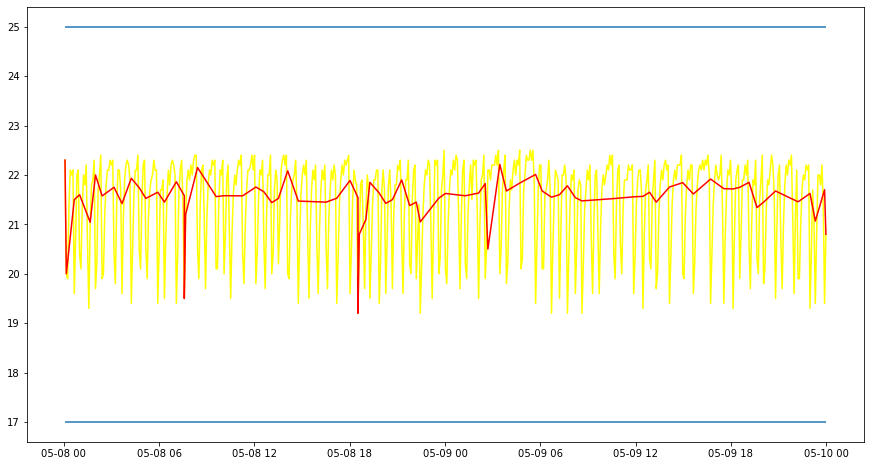

In [61]:
plt.plot(df.temp,'yellow')
# yellow values initial data 
plt.plot(optimized.temp , 'red')
# red values optimized 
plt.hlines(MIN , d.index[0] , d.index[len(d.index)-1])
plt.hlines(MAX , d.index[0] , d.index[len(d.index)-1]) 